# Анализ бизнес-показателей приложения

**Задание:**

Дана статистика о пользователях приложения, необходимо изучить поведение клиентов и посчитать окупаемость расходов на привлечение клиентов проведя анализ продуктовых, маркетинговых метрик. 
Это, вероятно, позволит перераспределить бюджет и снизить расходы на маркетинг.

**Описание исходных данных:**

* лог сервера с данными о посещениях сайта;
* выгрузка всех заказов за рассматриваемый период;
* статистика рекламных расходов.

# Подготовка данных

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
flist = [i for i in Path().glob('*.csv')]
flist

[WindowsPath('costs.csv'),
 WindowsPath('orders_log.csv'),
 WindowsPath('visits_log.csv')]

In [3]:
costs = pd.read_csv(flist[0])
orders = pd.read_csv(flist[1])
visits = pd.read_csv(flist[2])

In [4]:
costs['dt'] = pd.to_datetime(costs['dt'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])

In [5]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [6]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [7]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Проверка данных на наличие пропусков и дубликатов

In [8]:
visits.isna().sum(), costs.isna().sum(), orders.isna().sum(), \
visits.duplicated().sum(), costs.duplicated().sum(), orders.duplicated().sum()

(Device       0
 End Ts       0
 Source Id    0
 Start Ts     0
 Uid          0
 dtype: int64,
 source_id    0
 dt           0
 costs        0
 dtype: int64,
 Buy Ts     0
 Revenue    0
 Uid        0
 dtype: int64,
 0,
 0,
 0)

# Продуктовые метрики

Для начала из данных лога сервера можно посчитать количество уникальных пользователей в день и месяц **(DAU, MAU)** в общем и для разных типов устройств

In [9]:
visits['d_period'] = visits['Start Ts'].dt.to_period('d')
visits['m_period'] = visits['Start Ts'].dt.to_period('M')

dau = visits.groupby('d_period').agg({'Uid': 'nunique'})
mau = visits.groupby('m_period').agg({'Uid': 'nunique'})

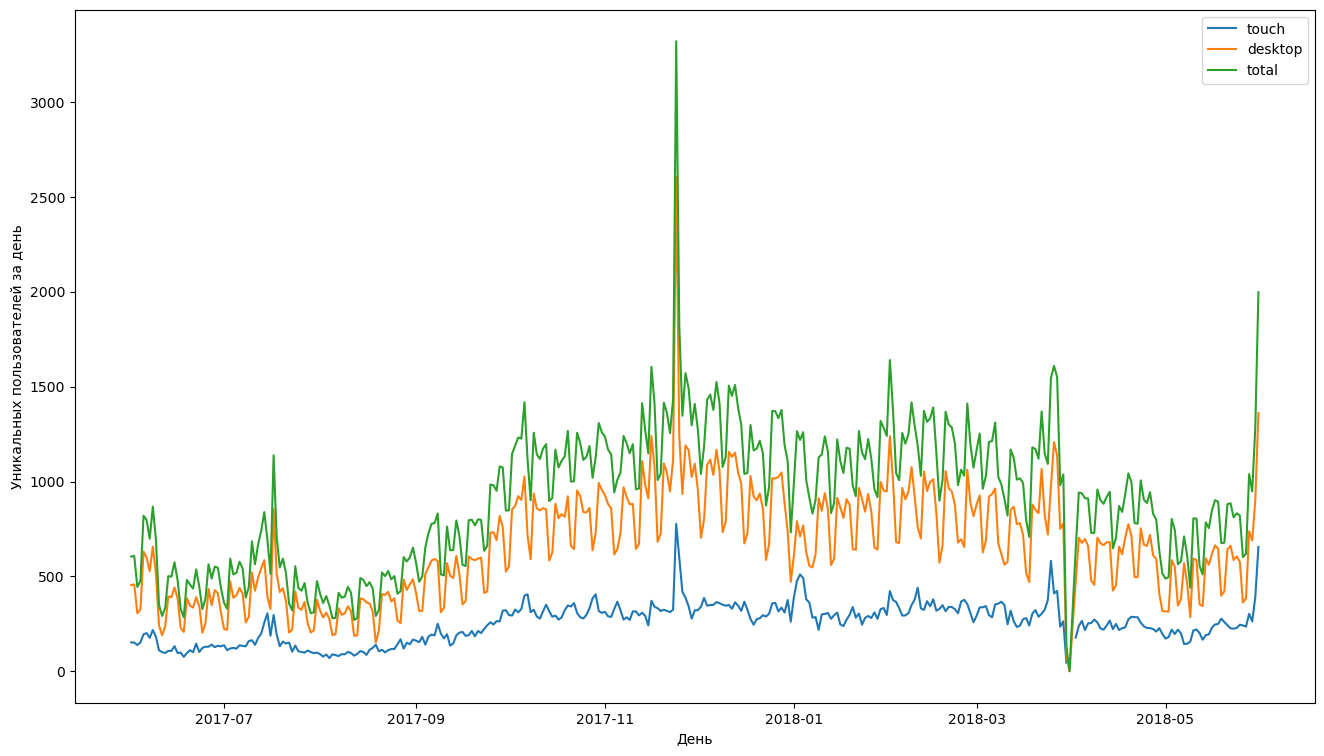

In [10]:
fig, ax = plt.subplots(figsize = (16, 9))
dau_by_device = pd.pivot_table(visits, 
              index = 'd_period',
              columns = 'Device',
              values = 'Uid',
              aggfunc = 'nunique')
ax.plot(dau_by_device.index.to_timestamp(), 
           dau_by_device['touch'].values, 
           label = 'touch')
ax.plot(dau_by_device.index.to_timestamp(), 
           dau_by_device['desktop'].values, 
           label = 'desktop')
ax.plot(dau.index.to_timestamp(), 
           dau.values, 
           label = 'total')
ax.set_ylabel('Уникальных пользователей за день')
ax.set_xlabel('День')
ax.legend()

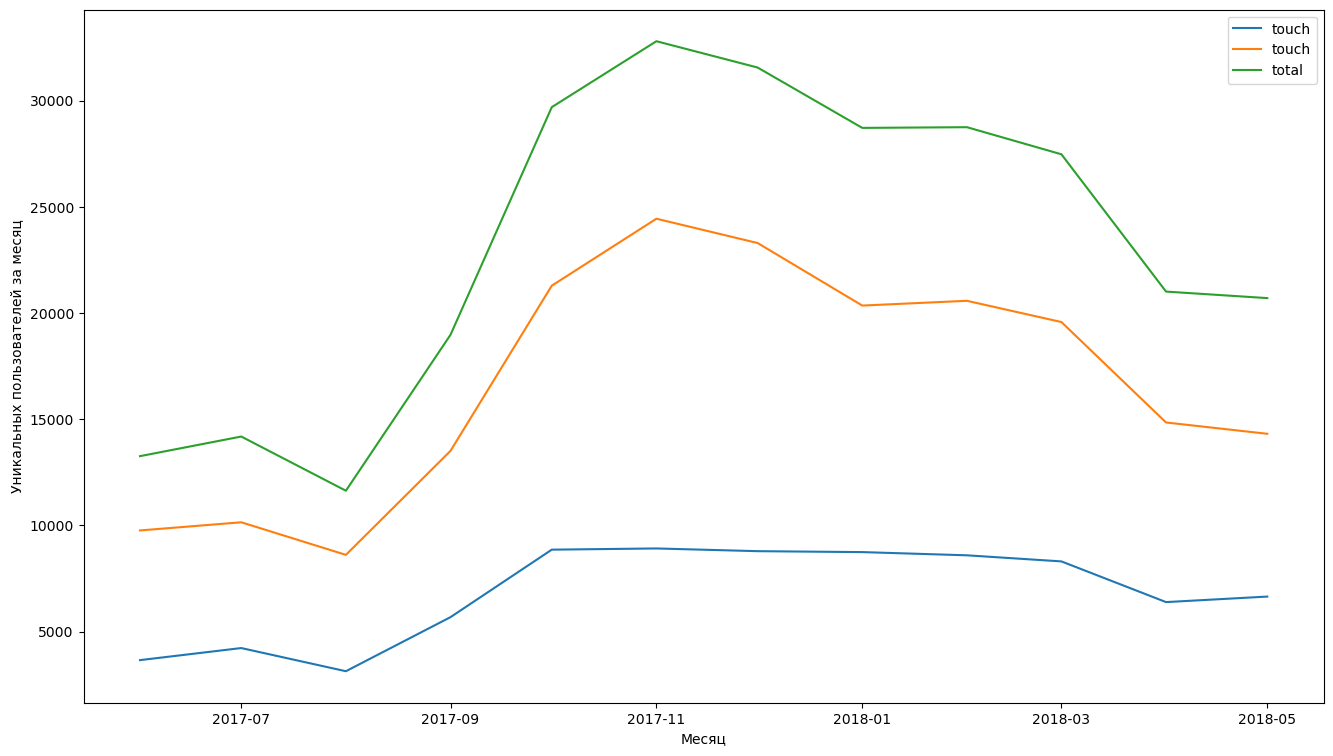

In [11]:
fig, ax = plt.subplots(figsize = (16, 9))
mau_by_device = pd.pivot_table(visits, 
              index = 'm_period',
              columns = 'Device',
              values = 'Uid',
              aggfunc = 'nunique')
ax.plot(mau_by_device.index.to_timestamp(), 
           mau_by_device['touch'].values, 
           label = 'touch')
ax.plot(mau_by_device.index.to_timestamp(), 
           mau_by_device['desktop'].values, 
           label = 'touch')
ax.plot(mau.index.to_timestamp(), 
           mau.values, 
           label = 'total')
ax.set_ylabel('Уникальных пользователей за месяц')
ax.set_xlabel('Месяц')
ax.legend()

In [12]:
pd.concat([dau_by_device.describe(), dau.rename(columns = {'Uid': 'total'}).describe()], axis = 1)

,desktop,touch,total
count,364.000000,363.000000,364.000000
mean,659.244505,252.873278,907.991758
std,284.771685,102.042757,370.513838
min,1.000000,46.000000,1.000000
25%,421.750000,173.500000,594.000000
50%,649.000000,264.000000,921.000000
75%,877.000000,322.000000,1173.000000
max,2605.000000,777.000000,3319.000000


Ещё одной важной метрикой является среднее количество посещений приложения пользователем за день

In [13]:
visits_per_day = visits.groupby(['d_period', 'Uid']).agg({'Uid': 'count'}).groupby('d_period').mean()
visits_per_day_touch = visits[visits['Device'] == 'touch'].\
groupby(['d_period', 'Uid']).agg({'Uid': 'count'}).groupby('d_period').mean()
visits_per_day_desktop = visits[visits['Device'] == 'desktop'].\
groupby(['d_period', 'Uid']).agg({'Uid': 'count'}).groupby('d_period').mean()

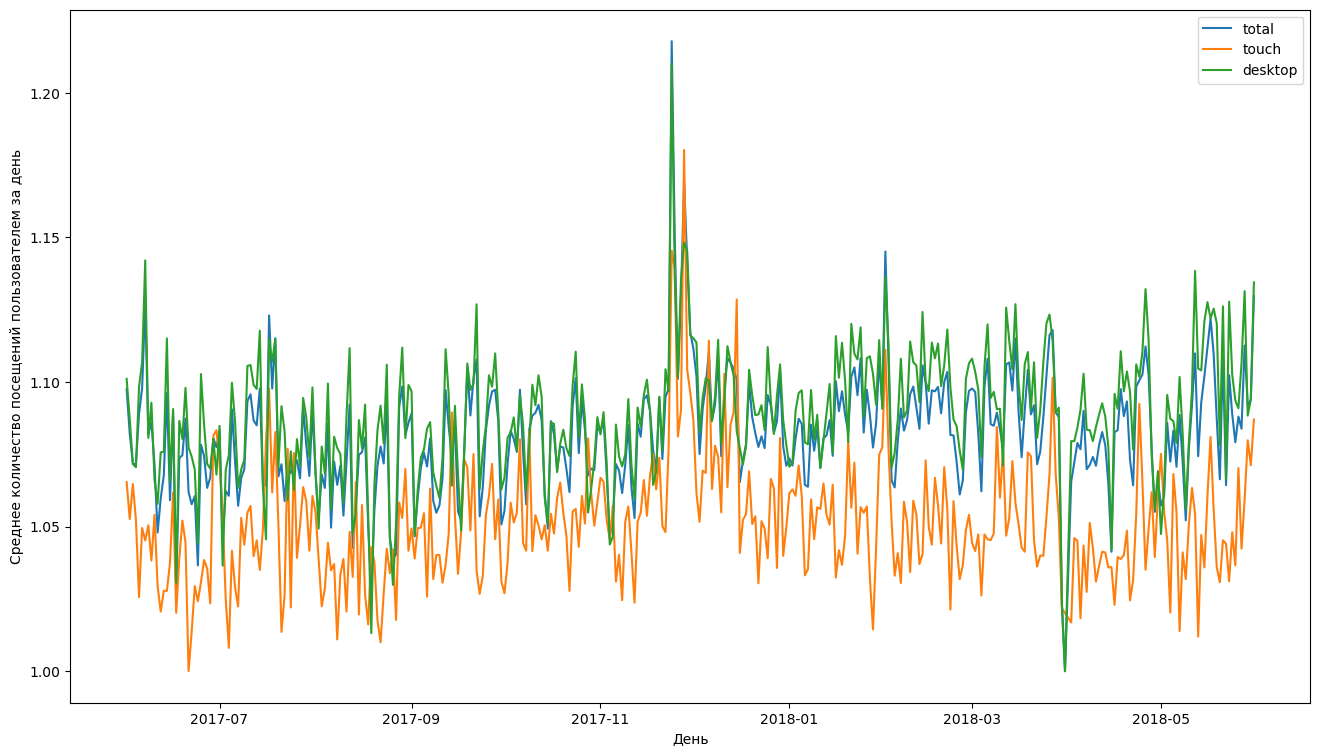

In [14]:
fig, ax = plt.subplots(figsize = (16, 9))

ax.plot(visits_per_day.index.to_timestamp(), 
           visits_per_day.values, label = 'total')
ax.plot(visits_per_day_touch.index.to_timestamp(), 
           visits_per_day_touch.values, label = 'touch')
ax.plot(visits_per_day_desktop.index.to_timestamp(), 
           visits_per_day_desktop.values, label = 'desktop')
ax.set_ylabel('Среднее количество посещений пользователем за день')
ax.set_xlabel('День')
ax.legend()

Средняя длительность сессии

In [15]:
visits['sessions_duration'] = (visits['End Ts'] - visits['Start Ts']).dt.seconds
visits['sessions_duration'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: sessions_duration, dtype: float64

In [16]:
visits['sessions_duration'].median()

300.0

Распределение длительности сессии

Text(0.5, 0, 'Количество секунд')

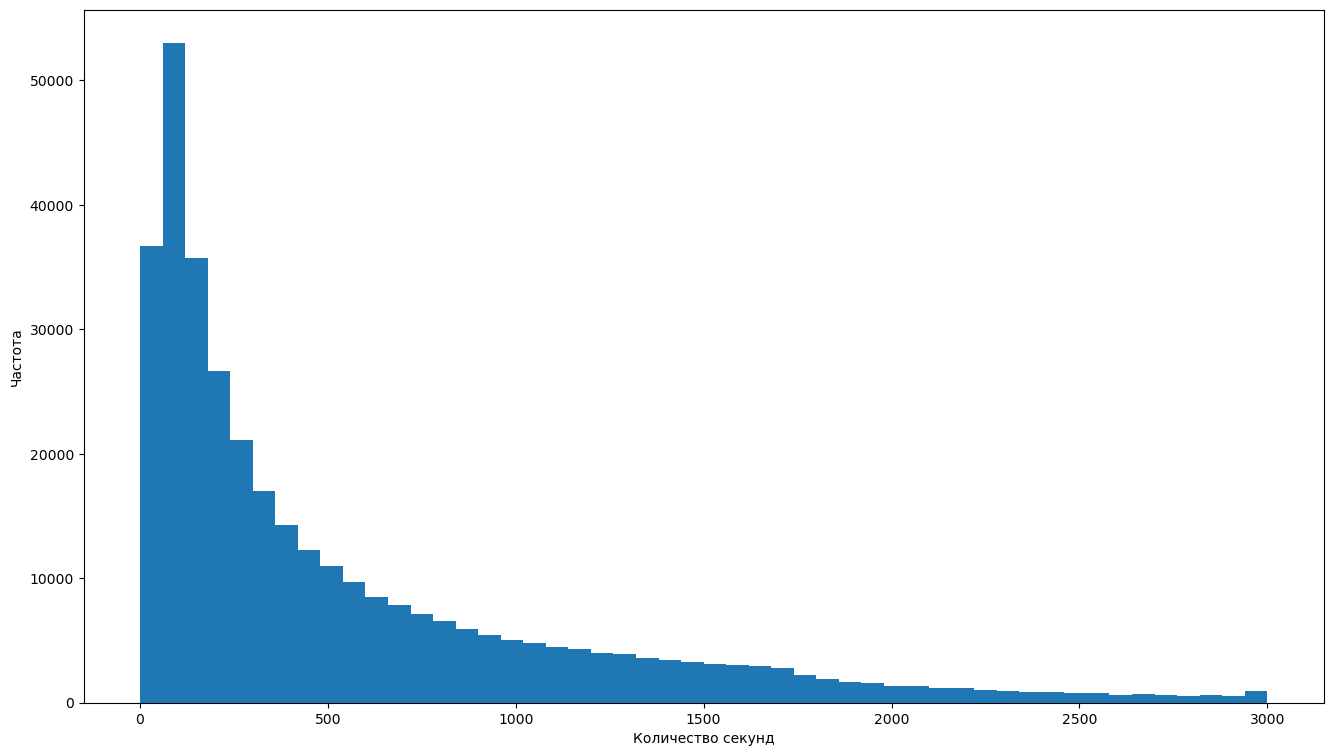

In [17]:
fig, ax = plt.subplots(figsize = (16, 9))

ax.hist(visits['sessions_duration'], bins = 50, range = (0, 3000))
ax.set_ylabel('Частота')
ax.set_xlabel('Количество секунд')

### Retention rate

In [18]:
first_enter = visits.groupby('Uid').agg({'Start Ts': 'min'}).to_dict()['Start Ts']
visits['first_enter'] = visits['Uid'].map(first_enter)
visits['first_enter_m'] = visits['first_enter'].dt.to_period('m')
visits['month_from_first_enter'] = \
((visits['m_period'].dt.to_timestamp() - visits['first_enter_m'].dt.to_timestamp()) \
 / np.timedelta64 ( 1 , 'M')).round().astype(int)

In [19]:
cohorts = visits.groupby(['first_enter_m','month_from_first_enter']).\
agg({'Uid':'nunique'}).reset_index()
cohorts_pivot = visits.pivot_table(index='first_enter_m',
                                  columns='month_from_first_enter',
                                  values='Uid',
                                  aggfunc='nunique')


In [20]:
retention_df = pd.concat([cohorts_pivot.iloc[:, i] / cohorts_pivot.iloc[:, 0].values for i in cohorts_pivot.columns],
         axis = 1)
retention_df.fillna('')

,0,1,2,3,4,5,6,7,8,9,10,11
first_enter_m,,,,,,,,,,,,
2017-06,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,
2017-08,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,,
2017-09,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.03586,0.024186,0.022809,,,
2017-10,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,,,,
2017-11,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.0218,,,,,
2017-12,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,,,,,,
2018-01,1.0,0.059715,0.039339,0.024973,0.020244,,,,,,,
2018-02,1.0,0.05708,0.025454,0.020093,,,,,,,,


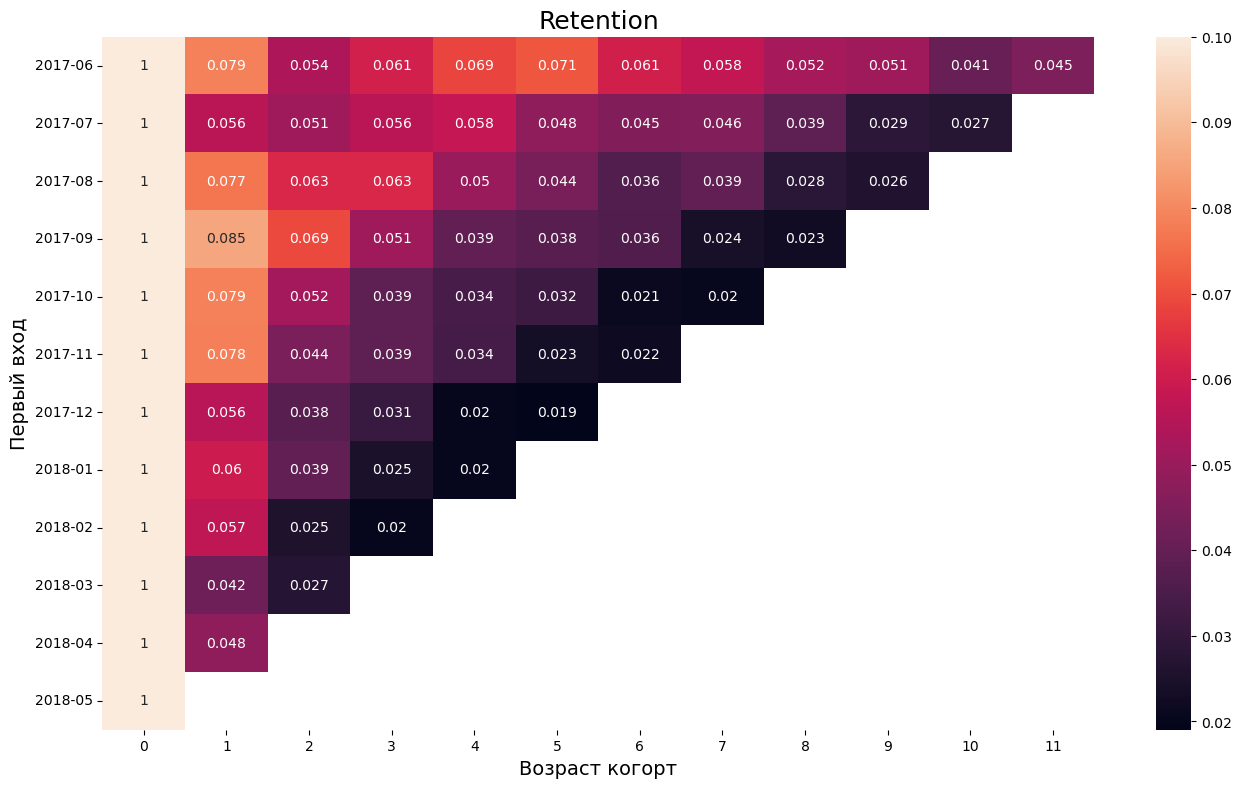

In [21]:
plt.figure(figsize = (16, 9))
sns.heatmap(retention_df, annot=True, vmax=0.1)
plt.title('Retention', fontsize=18)
plt.ylabel('Первый вход', fontsize=14)
plt.xlabel('Возраст когорт', fontsize=14)
plt.show()

Видно, что с течением времени удержание пользователей на любом лаге упало. Так, например, Retention Rate в первый месяц 2017-06 почти на 2/3 ниже, чем в первый месяц 2018-04. Примерно то же самое справедливо для всех остальных месяцев.

Полезно посчитать средний уровень удержания для всех месяцев

In [22]:
retention_df.mean()

0     1.000000
1     0.065167
2     0.046333
3     0.042760
4     0.040595
5     0.039444
6     0.036957
7     0.037509
8     0.035465
9     0.035159
10    0.034062
11    0.044951
dtype: float64

#### Сколько времени проходит перед тем, как пользователь сделает покупку после посещение сайта?

In [23]:
orders['firts_enter'] = orders['Uid'].map(first_enter)
orders['sec_before_buy'] = (orders['Buy Ts'] - orders['firts_enter']).dt.seconds
orders

,Buy Ts,Revenue,Uid,firts_enter,sec_before_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,60
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,660
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,120
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,900
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,1620
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,52740
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2700
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,120
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,41040


Распределение времени перед покупкой у пользователей

Text(0.5, 0, 'Количество секунд')

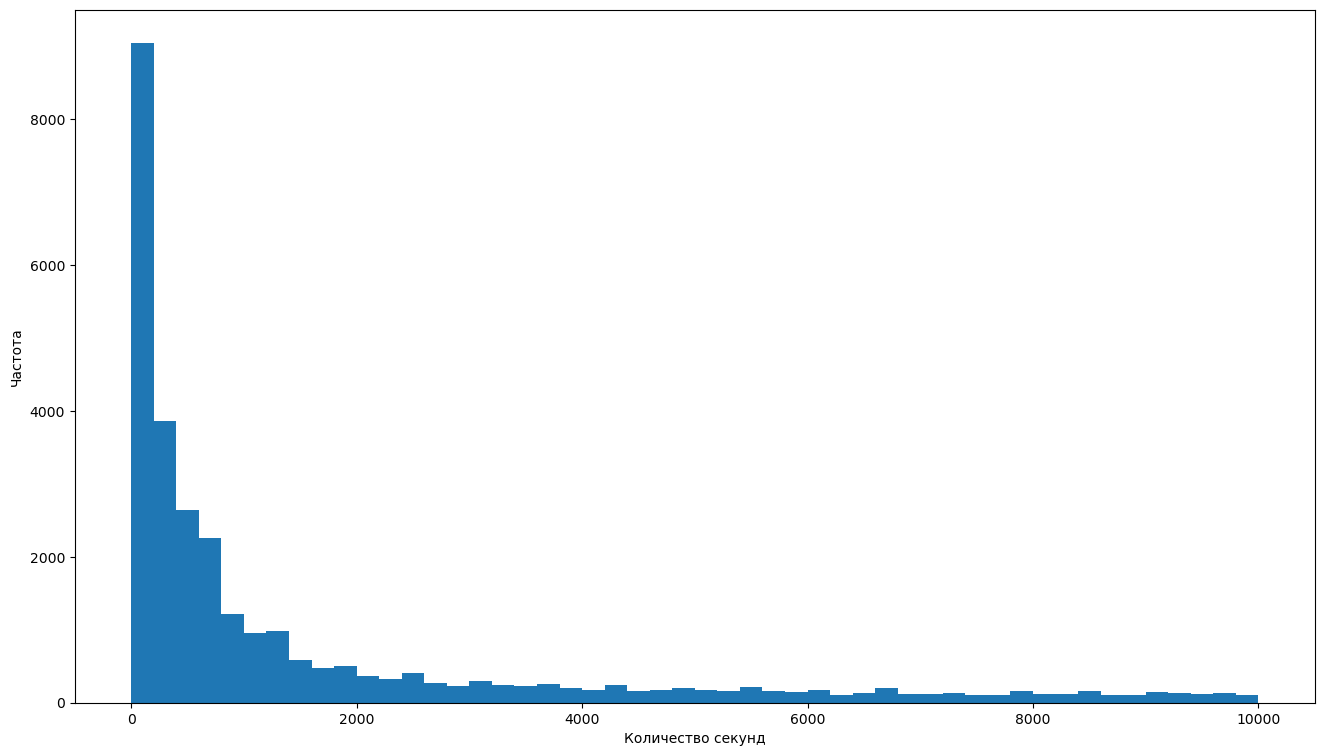

In [24]:
fig, ax = plt.subplots(figsize = (16, 9))

ax.hist(orders['sec_before_buy'], bins = 50, range = (0, 10000))
ax.set_ylabel('Частота')
ax.set_xlabel('Количество секунд')

Описательные статистики

In [25]:
orders['sec_before_buy'].mode()[0], orders['sec_before_buy'].median()

(60, 3840.0)

Среднее количество заказов пользователей по первому месяцу покупки

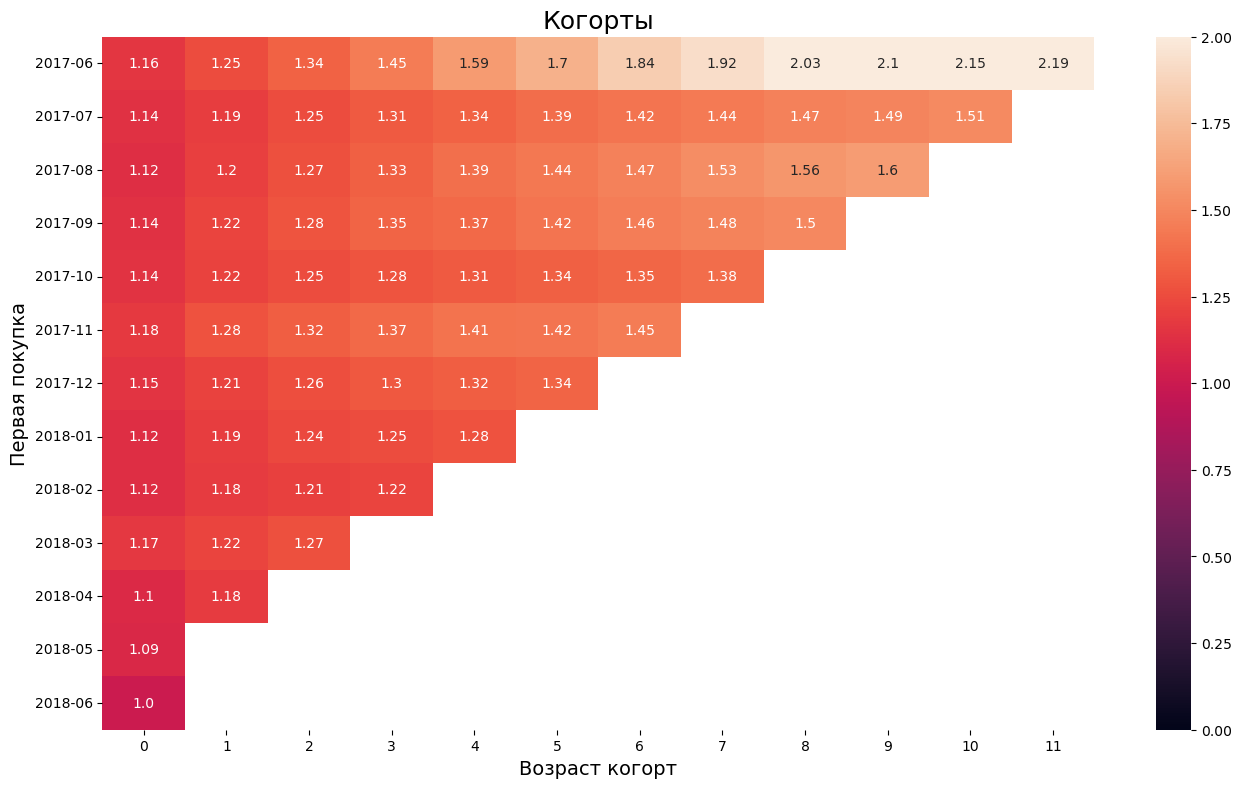

In [26]:
first_order = orders.groupby(['Uid'])['Buy Ts'].min().to_dict()
orders['first_order'] = orders['Uid'].map(first_order)

orders['month_from_first_order'] = ((orders['Buy Ts'].dt.to_period('M').dt.to_timestamp() - \
orders['first_order'].dt.to_period('M').dt.to_timestamp()) /\
np.timedelta64 ( 1 , 'M')).round().astype(int)
orders['buy_ts_month'] = \
orders['Buy Ts'].dt.to_period('M')#.dt.to_timestamp()

orders['first_order_month'] = \
orders['first_order'].dt.to_period('M')#.dt.to_timestamp()

cohorts = orders.groupby(['first_order_month', 'month_from_first_order']).\
agg(purchases=('buy_ts_month', 'count')).reset_index()

cohort_sizes = orders.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()

cohorts = cohorts.merge(cohort_sizes, on = 'first_order_month')

cohorts['avg_purchases'] = cohorts['purchases'] / cohorts['Uid']

cohorts_pivot = pd.pivot_table(cohorts,
    index='first_order_month',
    columns='month_from_first_order',           
    values='avg_purchases',
    aggfunc='sum')\
    .cumsum(axis=1)

plt.figure(figsize = (16, 9))
sns.heatmap(cohorts_pivot, fmt='.3', annot=True, vmax=2, vmin = 0)
plt.title('Когорты', fontsize=18)
plt.ylabel('Первая покупка', fontsize=14)
plt.xlabel('Возраст когорт', fontsize=14)
plt.show()

#### Средний чек

In [27]:
average_check = orders.groupby('buy_ts_month').agg({'Revenue': 'mean'})

Text(0.5, 0, 'Средний чек')

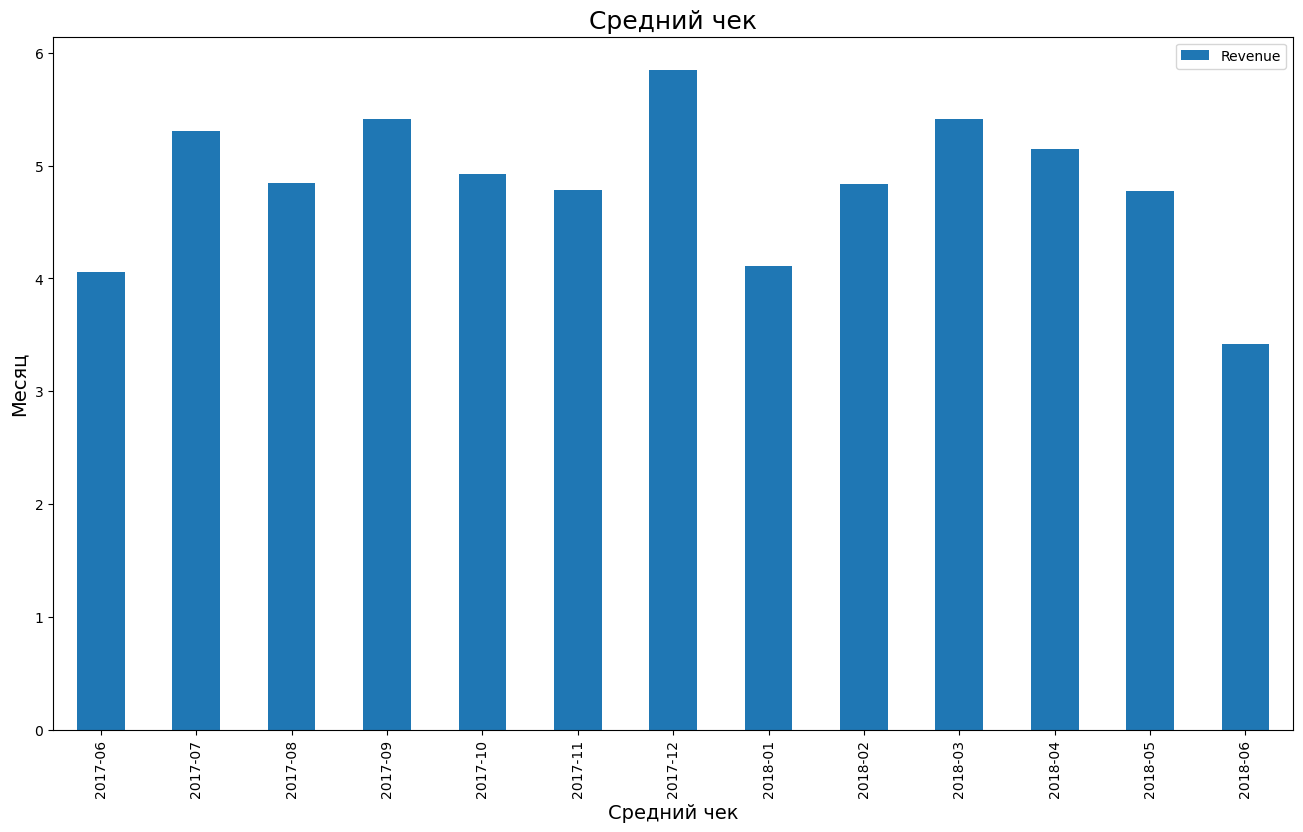

In [28]:
average_check.plot(kind = 'bar', figsize = (16, 9))
plt.title('Средний чек', fontsize=18)
plt.ylabel('Месяц', fontsize=14)
plt.xlabel('Средний чек', fontsize=14)


Средний чек по типу устройства

Text(0.5, 0, 'Средний чек')

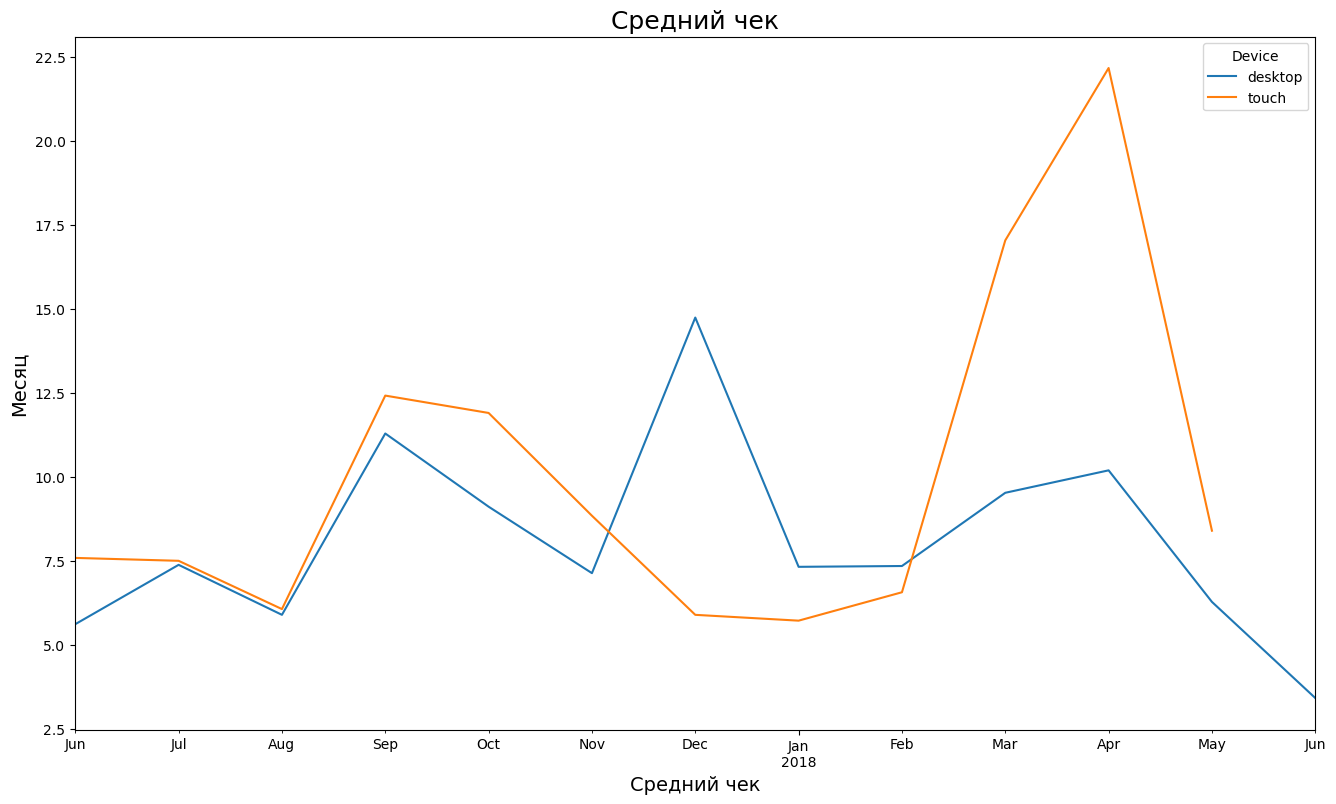

In [29]:
orders_by_devices = visits.merge(orders, on='Uid')

average_check_by_devices = orders_by_devices.pivot_table(index='buy_ts_month',
                                                            columns='Device',
                                                            values='Revenue',
                                                            aggfunc='mean')
average_check_by_devices.plot(kind = 'line', 
                        figsize=(16, 9))
plt.title('Средний чек', fontsize=18)
plt.ylabel('Месяц', fontsize=14)
plt.xlabel('Средний чек', fontsize=14)

## Маркетинговые метрики

#### Количество новых покупателей по месяцам

In [30]:
costs = pd.read_csv(flist[0])
orders = pd.read_csv(flist[1])
visits = pd.read_csv(flist[2])
costs['dt'] = pd.to_datetime(costs['dt'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])

In [31]:
first_enter = visits.groupby('Uid').agg({'Start Ts': 'min'}).to_dict()['Start Ts']
main_source=visits.sort_values('Start Ts').groupby('Uid').\
            agg({'Source Id':'first'}).to_dict()['Source Id']

orders['Buy_Ts_month'] = orders['Buy Ts'].dt.to_period('m')
first_order = orders.groupby('Uid').agg({'Buy_Ts_month': 'min'}).to_dict()['Buy_Ts_month']


visits['first_enter'] = visits['Uid'].map(first_enter)
visits['first_enter_m'] = visits['Uid'].map(first_enter).dt.to_period('m')
visits['main_source'] = visits['Uid'].map(main_source)

orders['main_source'] = orders['Uid'].map(main_source)
orders['first_enter_m'] = orders['Uid'].map(first_enter).dt.to_period('m')
orders['first_order_m'] = orders['Uid'].map(first_order)
orders['age'] = (orders['Buy_Ts_month'].dt.to_timestamp() - orders['first_order_m'].dt.to_timestamp()) / np.timedelta64(1, 'M')
orders['age'] = orders['age'].round().astype('int')

costs['dt_month'] = costs['dt'].dt.to_period('m')

In [32]:
rev = orders.groupby(['first_order_m', 'age']).agg({'Revenue': 'sum'}).reset_index()
rev

,first_order_m,age,Revenue
0,2017-06,0,9557.49
1,2017-06,1,981.82
2,2017-06,2,885.34
3,2017-06,3,1931.30
4,2017-06,4,2068.58
...,...,...,...
74,2018-03,2,1114.87
75,2018-04,0,10600.69
76,2018-04,1,1209.92
77,2018-05,0,13925.76


In [33]:
buyers_num = orders.groupby(['first_order_m']).agg({'Uid': 'nunique'}).reset_index()
buyers_num

,first_order_m,Uid
0,2017-06,2023
1,2017-07,1923
2,2017-08,1370
3,2017-09,2581
4,2017-10,4340
5,2017-11,4081
6,2017-12,4383
7,2018-01,3373
8,2018-02,3651
9,2018-03,3533


In [34]:
res = pd.merge(rev, buyers_num, on = ['first_order_m']).rename(columns = {'Uid': 'buyers_num'})
res

,first_order_m,age,Revenue,buyers_num
0,2017-06,0,9557.49,2023
1,2017-06,1,981.82,2023
2,2017-06,2,885.34,2023
3,2017-06,3,1931.30,2023
4,2017-06,4,2068.58,2023
...,...,...,...,...
74,2018-03,2,1114.87,3533
75,2018-04,0,10600.69,2276
76,2018-04,1,1209.92,2276
77,2018-05,0,13925.76,2988


#### LTV

In [35]:
res['ltv'] = res['Revenue'] / res['buyers_num']
res

,first_order_m,age,Revenue,buyers_num,ltv
0,2017-06,0,9557.49,2023,4.724414
1,2017-06,1,981.82,2023,0.485329
2,2017-06,2,885.34,2023,0.437637
3,2017-06,3,1931.30,2023,0.954671
4,2017-06,4,2068.58,2023,1.022531
...,...,...,...,...,...
74,2018-03,2,1114.87,3533,0.315559
75,2018-04,0,10600.69,2276,4.657597
76,2018-04,1,1209.92,2276,0.531599
77,2018-05,0,13925.76,2988,4.660562


<Axes: title={'center': 'LTV'}, xlabel='age', ylabel='first_order_m'>

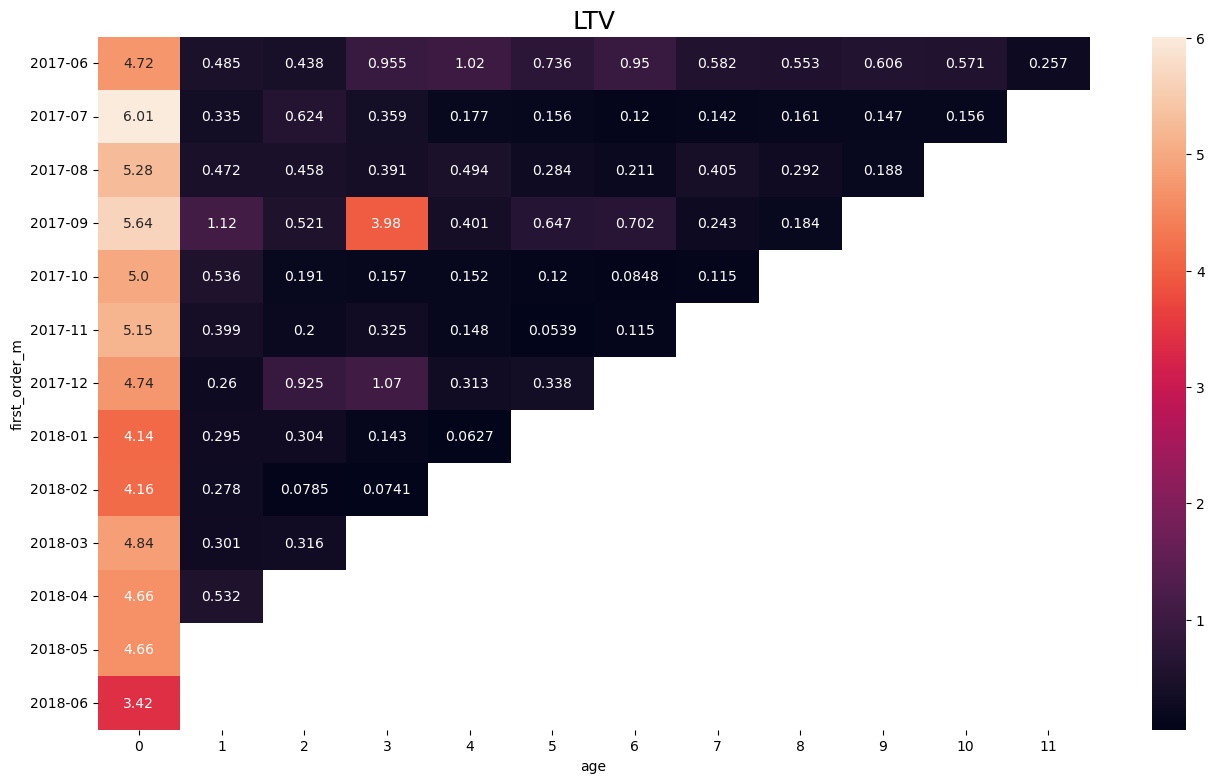

In [36]:
output = res.pivot_table(index='first_order_m', 
                            columns='age', 
                            values='ltv', 
                            aggfunc='sum')

plt.figure(figsize=(16, 9))
plt.title('LTV', fontsize=18)
sns.heatmap(output, annot=True, fmt='.3')

<Axes: title={'center': 'LTV'}, xlabel='age', ylabel='first_order_m'>

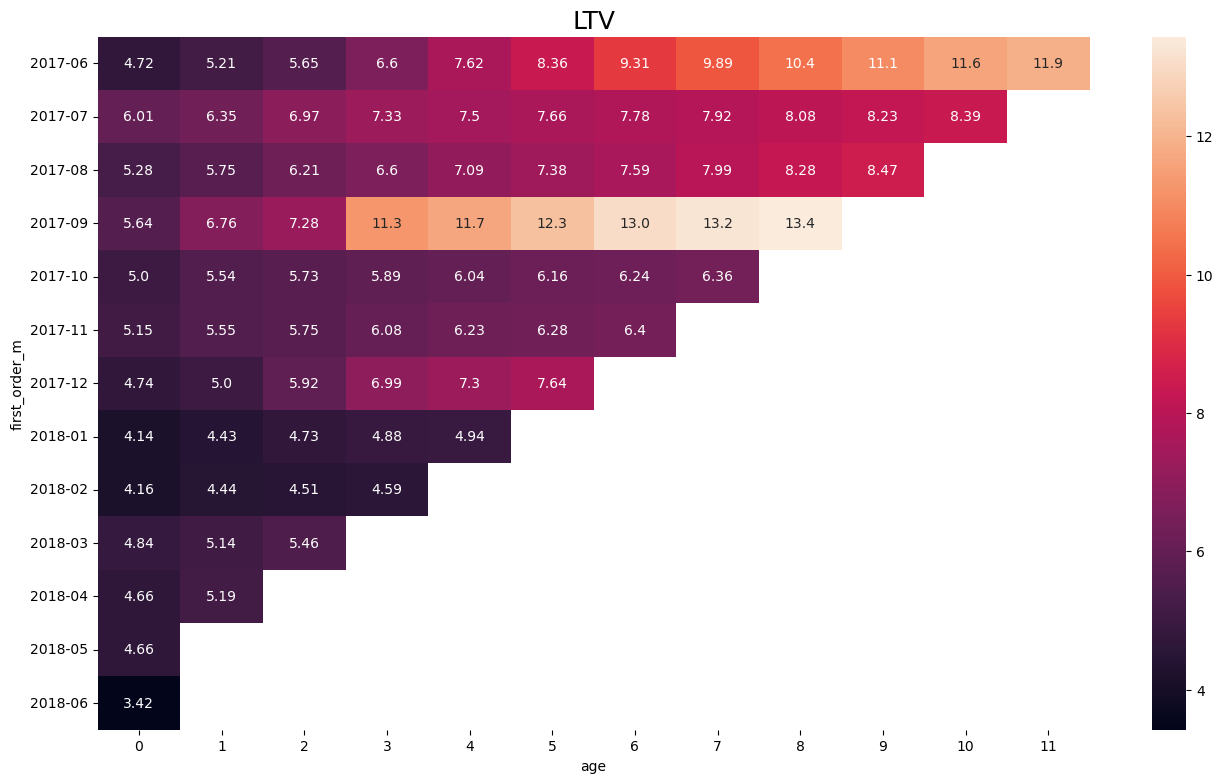

In [37]:
plt.figure(figsize=(16, 9))
plt.title('LTV', fontsize=18)
sns.heatmap(output.cumsum(axis = 1).round(2), annot=True, fmt='.3')

LTV в течение периода сильно вариируется. Так, например, пользователи из первой когорты за 12 месяцев принесли почти столько же денег, сколько пользователи из 6 когорты за 6 месяцев

Затраты на рекламу по месяцам

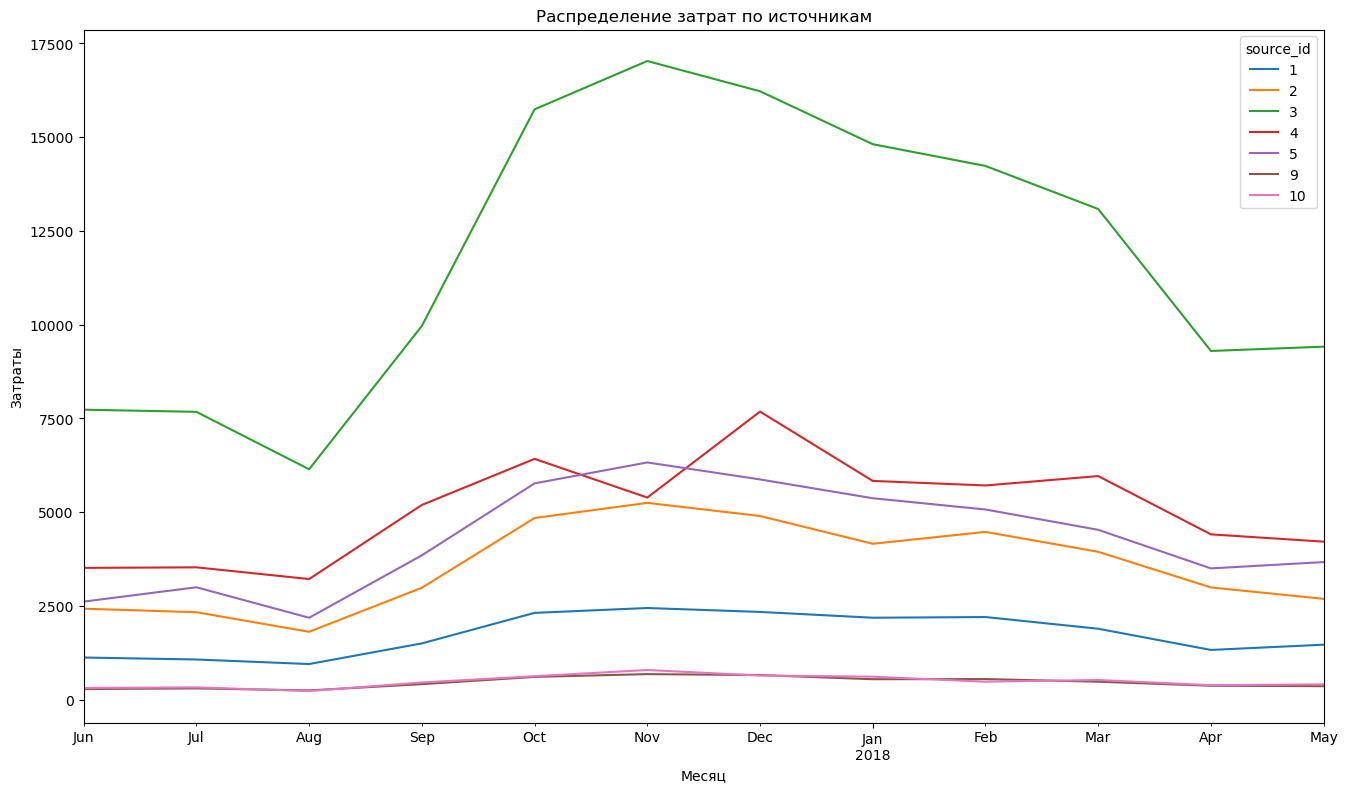

In [48]:
cost_by_source = pd.pivot_table(costs, index='dt_month', columns='source_id', 
                                 values='costs', aggfunc='sum')
cost_by_source.plot(kind='line', figsize=(16, 9))

plt.title("Распределение затрат по источникам")
plt.xlabel("Месяц")
plt.ylabel("Затраты")
plt.show()

#### CAC и ROMI

In [38]:
res['costs'] = res['first_order_m'].map(costs.groupby(['dt_month']).agg({'costs': 'sum'}).to_dict()['costs'])
res['cac'] = res['costs'] / res['buyers_num']
res['romi'] = res['ltv'] / res['cac']

<Axes: title={'center': 'ROMI'}, xlabel='age', ylabel='first_order_m'>

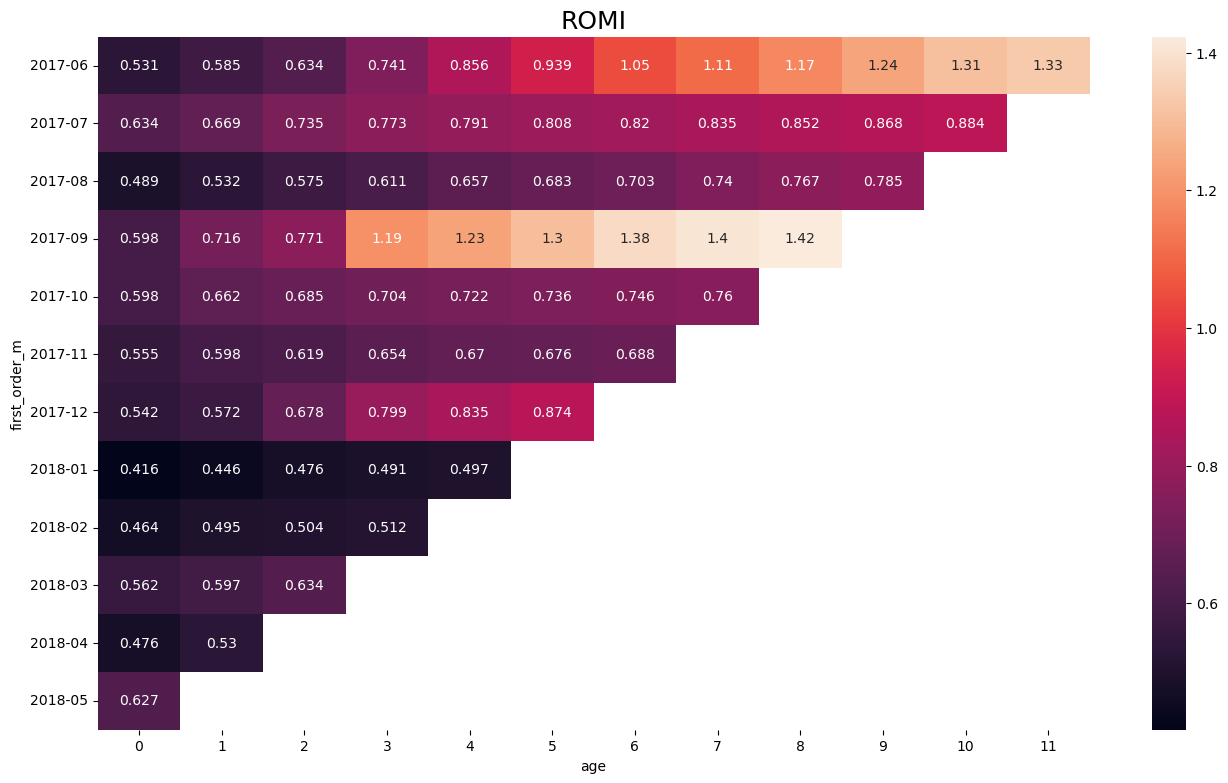

In [39]:
romi = pd.pivot_table(res,
               index = 'first_order_m',
               columns = 'age',
               values = 'romi').cumsum(axis = 1)

plt.figure(figsize=(16, 9))
plt.title('ROMI', fontsize=18)
sns.heatmap(romi, annot=True, fmt='.3')

#### ROMI по источнику

In [40]:
cust_by_source = orders.groupby('main_source')['Uid'].nunique()
costs_by_source = costs.groupby('source_id')['costs'].sum()

In [41]:
rev_source = orders.groupby(['main_source', 'first_order_m', 'Buy_Ts_month'])\
.agg({'Revenue': 'sum'}).reset_index()
rev_source

,main_source,first_order_m,Buy_Ts_month,Revenue
0,1,2017-06,2017-06,1378.70
1,1,2017-06,2017-07,414.98
2,1,2017-06,2017-08,419.43
3,1,2017-06,2017-09,714.24
4,1,2017-06,2017-10,811.20
...,...,...,...,...
511,10,2018-03,2018-03,638.44
512,10,2018-03,2018-04,12.71
513,10,2018-03,2018-05,6.29
514,10,2018-04,2018-04,261.93


In [42]:
res_source = (
    orders.groupby(['first_order_m','main_source'])
    .agg({'Uid': 'nunique'})
    .reset_index()
)

res_source

,first_order_m,main_source,Uid
0,2017-06,1,190
1,2017-06,2,235
2,2017-06,3,638
3,2017-06,4,413
4,2017-06,5,384
...,...,...,...
81,2018-05,4,804
82,2018-05,5,497
83,2018-05,9,60
84,2018-05,10,130


In [43]:
res_source = rev_source.merge(res_source, on = ['first_order_m', 'main_source'])
res_source['ltv'] = res_source['Revenue'] / res_source['Uid']
res_source

,main_source,first_order_m,Buy_Ts_month,Revenue,Uid,ltv
0,1,2017-06,2017-06,1378.70,190,7.256316
1,1,2017-06,2017-07,414.98,190,2.184105
2,1,2017-06,2017-08,419.43,190,2.207526
3,1,2017-06,2017-09,714.24,190,3.759158
4,1,2017-06,2017-10,811.20,190,4.269474
...,...,...,...,...,...,...
511,10,2018-03,2018-03,638.44,186,3.432473
512,10,2018-03,2018-04,12.71,186,0.068333
513,10,2018-03,2018-05,6.29,186,0.033817
514,10,2018-04,2018-04,261.93,107,2.447944


In [58]:
costs_by_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [59]:
cust_by_source

main_source
1      2899
2      3506
3     10473
4     10296
5      6931
7         1
9      1088
10     1329
Name: Uid, dtype: int64

In [44]:
res_source['age'] = (res_source['Buy_Ts_month'].dt.to_timestamp() - res_source['first_order_m'].dt.to_timestamp()) / np.timedelta64(1, 'M')
res_source['age'] = res_source['age'].round().astype('int')
res_source['costs'] = res_source['main_source'].map(costs_by_source.to_dict())
res_source['customers'] = res_source['main_source'].map(cust_by_source.to_dict())
res_source['cac'] = res_source['costs'] / res_source['customers']
res_source['romi_source'] = res_source['ltv'] / res_source['cac']
res_source

,main_source,first_order_m,Buy_Ts_month,Revenue,Uid,ltv,age,costs,customers,cac,romi_source
0,1,2017-06,2017-06,1378.70,190,7.256316,0,20833.27,2899,7.186364,1.009734
1,1,2017-06,2017-07,414.98,190,2.184105,1,20833.27,2899,7.186364,0.303924
2,1,2017-06,2017-08,419.43,190,2.207526,2,20833.27,2899,7.186364,0.307183
3,1,2017-06,2017-09,714.24,190,3.759158,3,20833.27,2899,7.186364,0.523096
4,1,2017-06,2017-10,811.20,190,4.269474,4,20833.27,2899,7.186364,0.594108
...,...,...,...,...,...,...,...,...,...,...,...
511,10,2018-03,2018-03,638.44,186,3.432473,0,5822.49,1329,4.381106,0.783472
512,10,2018-03,2018-04,12.71,186,0.068333,1,5822.49,1329,4.381106,0.015597
513,10,2018-03,2018-05,6.29,186,0.033817,2,5822.49,1329,4.381106,0.007719
514,10,2018-04,2018-04,261.93,107,2.447944,0,5822.49,1329,4.381106,0.558750


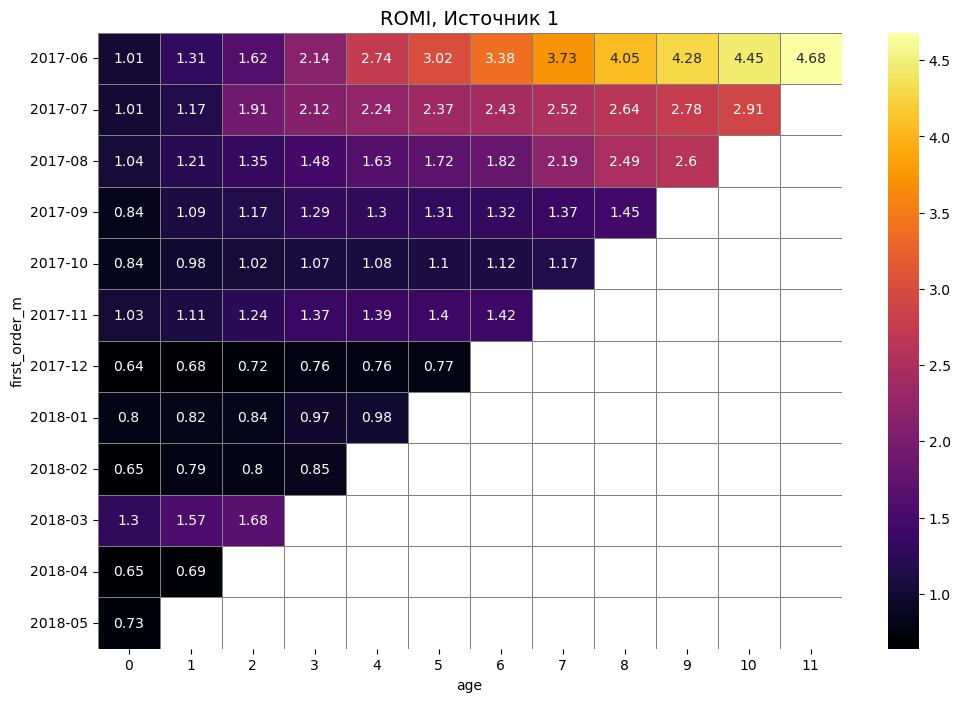

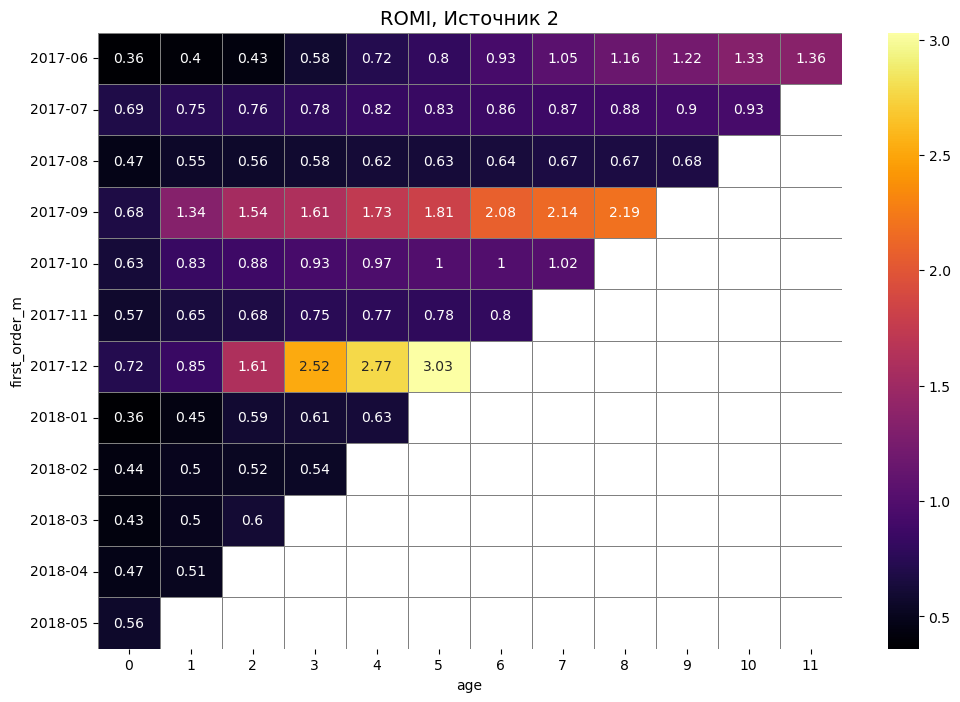

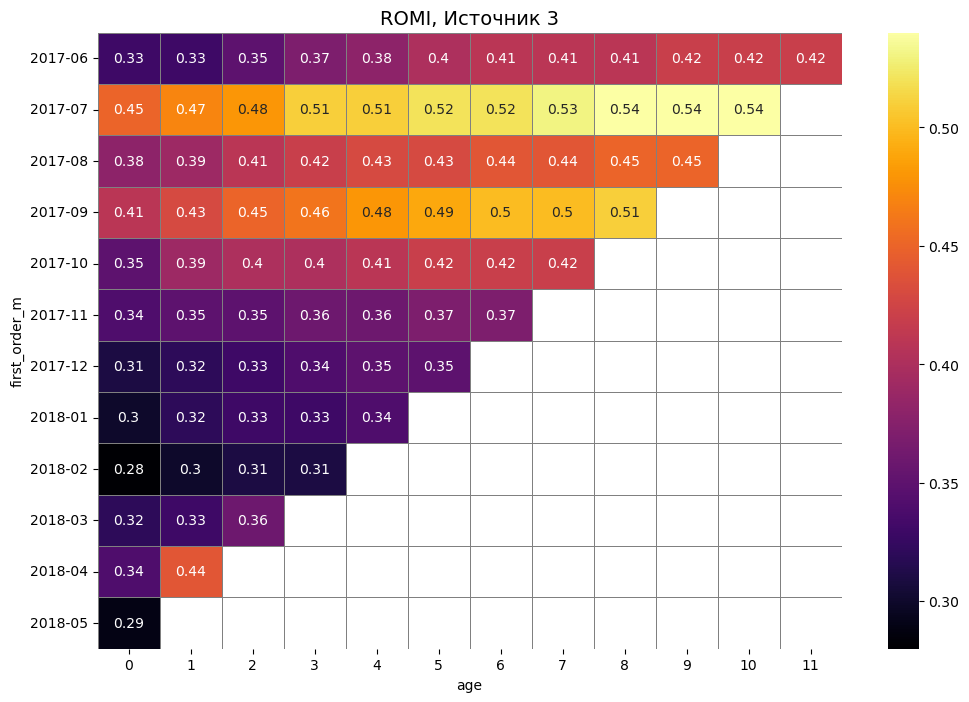

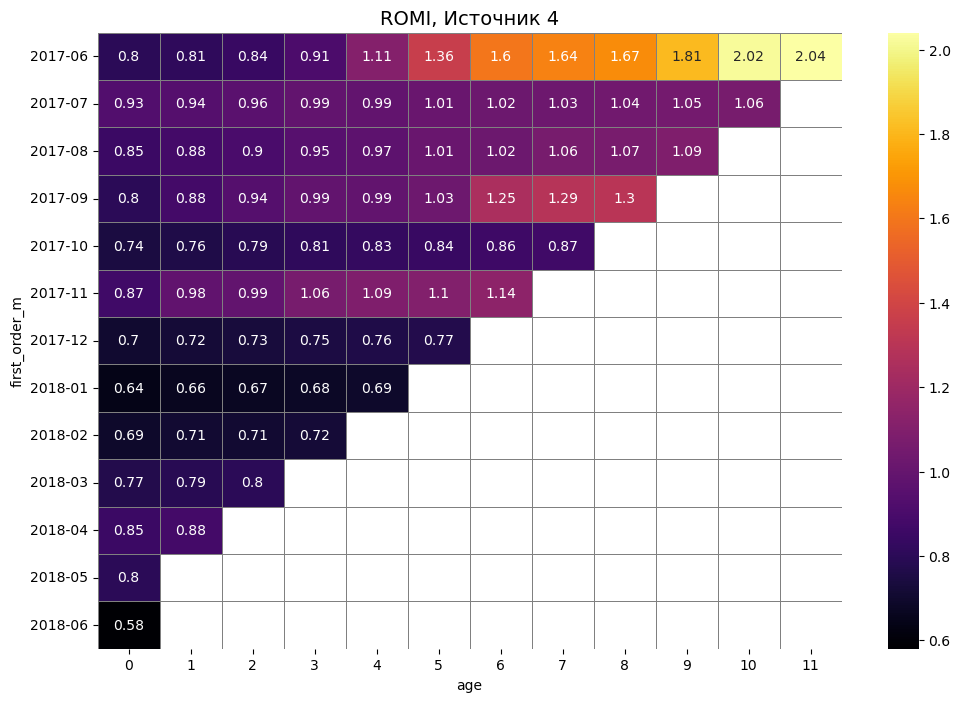

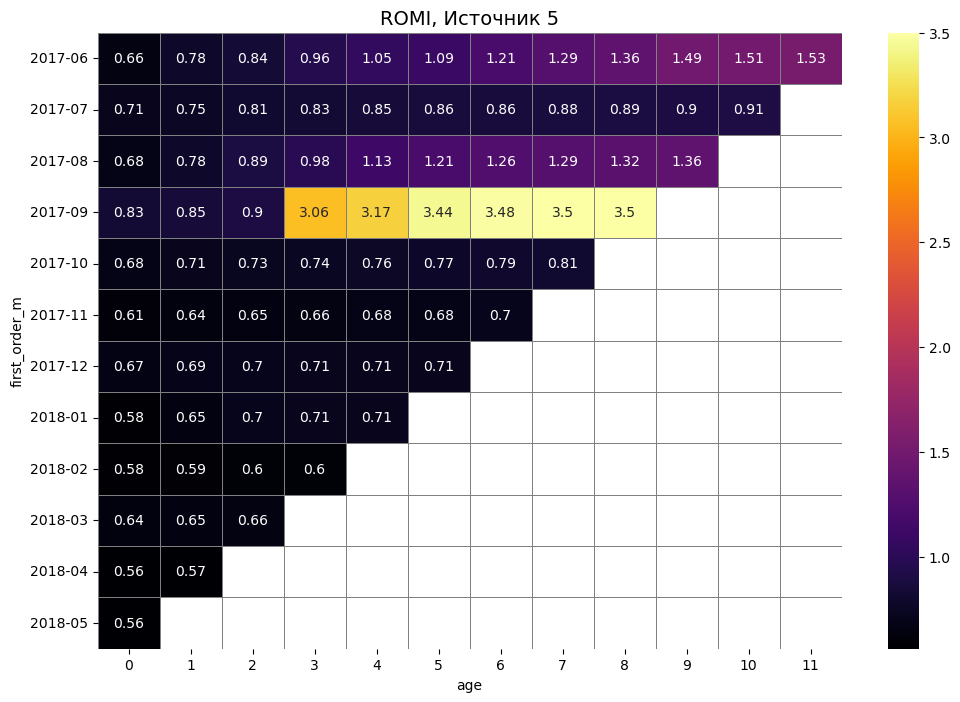

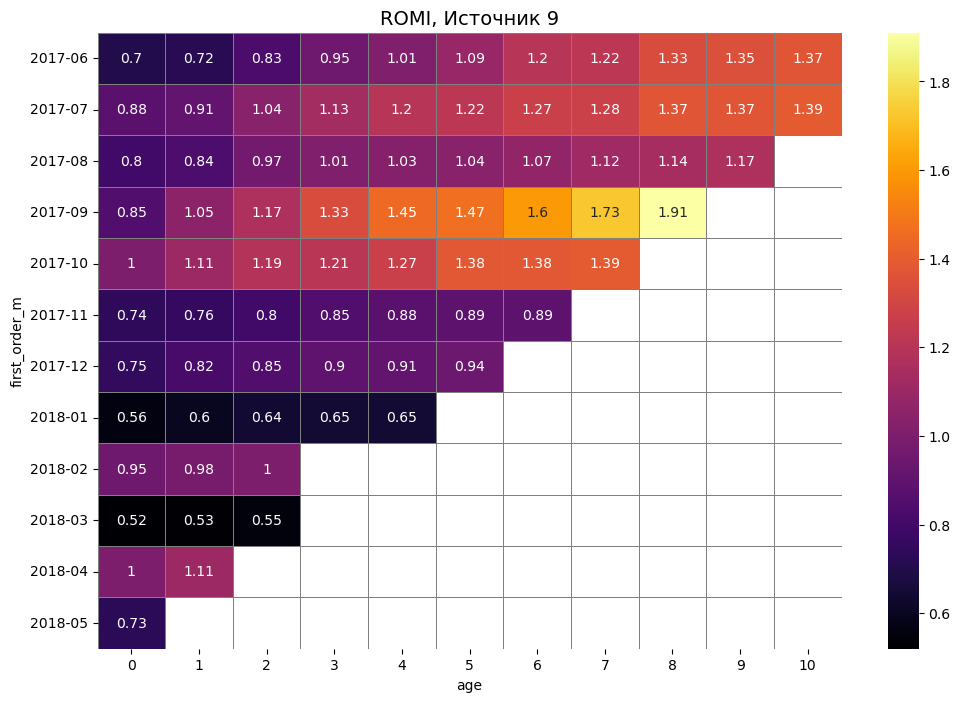

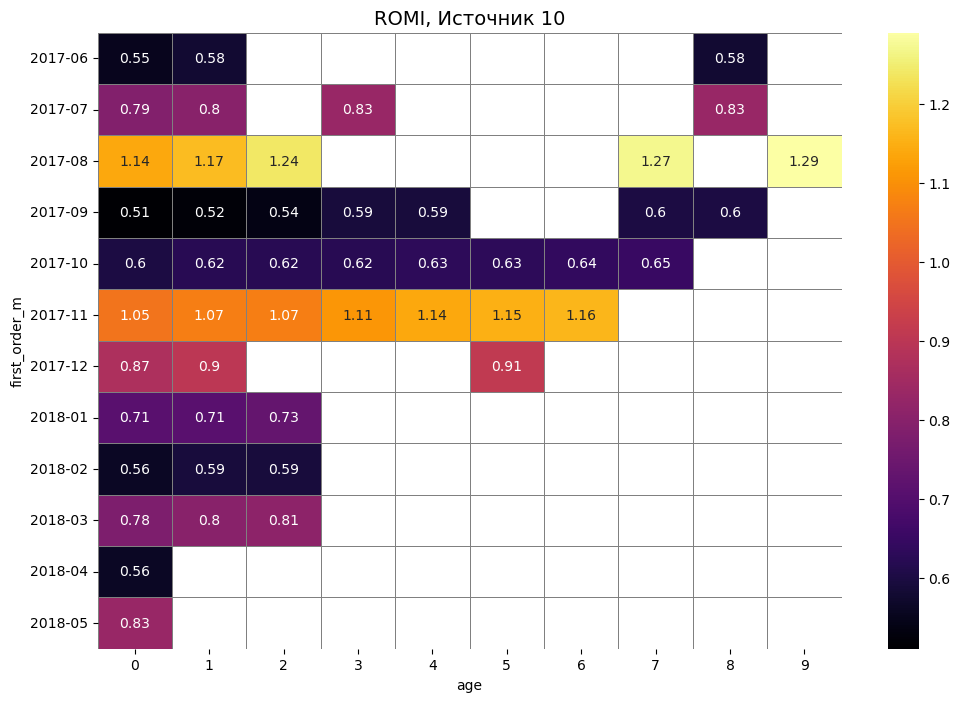

In [45]:
for source in pd.unique(res_source['main_source']):
    if source == 7:
        continue
    romi_pivot = (res_source.query('main_source == @source')
                    .pivot_table(index='first_order_m', 
                                 columns='age', 
                                 values='romi_source', 
                                 aggfunc='mean').cumsum(axis=1).round(2)
                   )

    plt.figure(figsize=(12, 8))
    sns.heatmap(romi_pivot, annot=True, fmt='.3g', 
                linewidths=0.5, linecolor='gray', cmap='inferno')
    plt.title(f'ROMI, Источник {source}', fontsize=14)
    plt.show()

In [62]:
romi_mean = res_source.pivot_table(
    index='main_source',
    columns='age', 
    values='romi_source').cumsum(axis=1)
romi_mean

age,0,1,2,3,4,5,6,7,8,9,10,11
main_source,,,,,,,,,,,,
1,0.878676,1.024383,1.186210,1.341228,1.454781,1.534704,1.628807,1.808402,2.014161,2.173207,2.321597,2.554070
2,0.532533,0.668018,0.804023,0.952769,1.037396,1.104825,1.181060,1.230495,1.272098,1.300686,1.371218,1.406706
3,0.341309,0.365059,0.378652,0.389744,0.398334,0.404904,0.409940,0.415899,0.422073,0.425896,0.428998,0.431383
4,0.770610,0.803549,0.824572,0.859590,0.897178,0.950606,1.039892,1.066795,1.085666,1.141120,1.249926,1.264237
5,0.647463,0.689199,0.727734,0.998212,1.046927,1.107459,1.148738,1.182752,1.213254,1.268469,1.283925,1.299545
9,0.790423,0.852416,0.923762,0.993606,1.037315,1.077309,1.130146,1.175801,1.272343,1.291847,1.307122,NaN
10,0.745889,0.764063,0.781825,0.812832,0.825868,0.834768,0.843299,0.857426,0.860552,0.881280,NaN,NaN


На данный момент все источники рекламы, кроме 3 и 10, окупились. Наиболее удачным оказался первый источник 1.

## Выводы

Количество посетителей и покупателей с устройств desktop и touch отличается. Пользователи desktop посещают и делают покупки примерно в 3 раза чаще, но средний чек с устройства touch выше на 25%. Модальное время покупки после посещения сайта - 60 секунд после начала сессии. Необходимо проанализировать работу с устройством touch и выяснить причины меньшего количества посещений и покупок с данной платформы, несмотря на более высокий средний чек.

В первой когорте средний Retention Rate составляет 6,5%. В последующих когортах Retention Rate убывает быстрее, особенно в зимние месяцы. Таким образом, летние посетители чаще возвращаются на сайт. Для улучшения Retention Rate рекомендуется оптимизировать рекламу, чтобы снизить число "случайных кликов", т.е. пользователей, которые никогда не делают покупки. Также стоит рассмотреть внедрение программы лояльности для постоянных клиентов, таких как система скидок, кэшбэк или бонусные баллы.

В среднем каждый покупатель делает не более одной покупки на сайте за полгода, при этом большая часть покупок происходит в первый месяц жизни каждой когорты. Эта метрика связана с Retention Rate и указывает на небольшое количество постоянных покупателей.

Средний LTV (пожизненная стоимость клиента) по когортам за полгода составляет 8 у.е. в месяц. В каждой последующей когорте темпы роста LTV замедляются. Это может быть связано либо со снижением платежеспособности покупателей, либо с потерей их интереса к сервису.

Самый эффективный источник привлечения рекламы - 1 источник, источники 2, 3, 4, 9 окупились уже на 6 месяце, когда как источники 10 и 3 не окупились. Компании следует дальше использовать эффективные источники привлечения клиентов